In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import warnings

def chemoattractant_gradient_linear(x, y):
    """
    Calculates the concentration of the chemoattractant for a linear gradient.

    Args:
        x: x-coordinate.
        y: y-coordinate.

    Returns:
        Concentration of the chemoattractant.
    """
    return x  # Linear gradient along the x-axis

def chemoattractant_gradient_radial(x, y):
    """
    Calculates the concentration of the chemoattractant for a radial gradient 
    in the upper right corner.

    Args:
        x: x-coordinate.
        y: y-coordinate.

    Returns:
        Concentration of the chemoattractant.
    """
    # Calculate distance from the upper right corner
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    return 1 - distance

def calculate_chemotaxis_bias(x, y, gradient_function):
  """
  Calculates the bias in movement direction due to the chemoattractant gradient.

  Args:
    x: x-coordinate.
    y: y-coordinate.
    gradient_function: The function to use for calculating the gradient.

  Returns:
    A tuple representing the bias in the x and y directions.
  """
  # Calculate gradient components (approximation)
  dx = gradient_function(x + 0.1, y) - gradient_function(x, y)
  dy = gradient_function(x, y + 0.1) - gradient_function(x, y)

  # Normalize the gradient vector
  gradient_magnitude = np.sqrt(dx**2 + dy**2)
  if gradient_magnitude > 0:
    dx /= gradient_magnitude
    dy /= gradient_magnitude

  return dx, dy

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #  [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #  [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #  ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

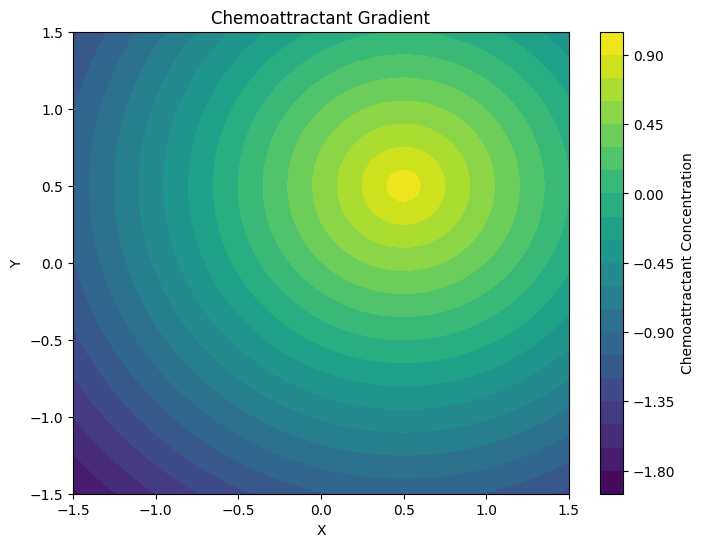

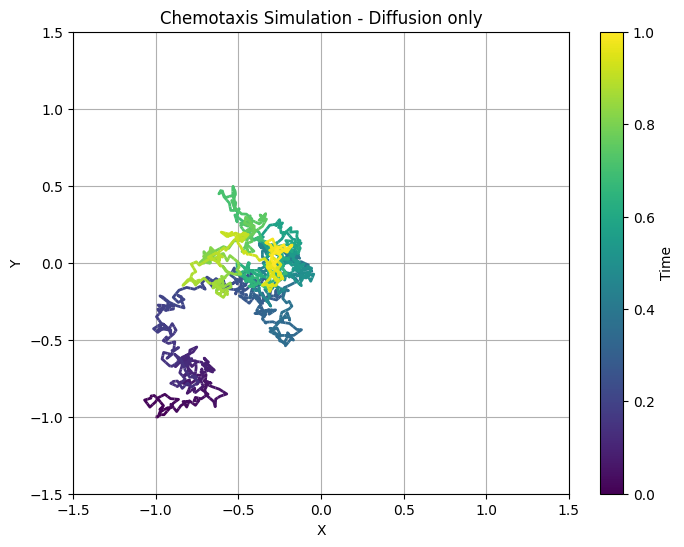

In [29]:
# Simulation parameters
num_steps = 1000
step_size = 0.05
chemotaxis_strength = 0.00  # Adjust this value to control the strength of chemotaxis

# Initialize
x = -1
y = -1
positions = [(x, y)]

# Choose gradient function (linear or radial)
#gradient_function = chemoattractant_gradient_linear  # Or 
gradient_function = chemoattractant_gradient_radial

# Simulate with chemotaxis
for _ in range(num_steps):
    # Calculate chemotaxis bias
    bias_x, bias_y = calculate_chemotaxis_bias(x, y, gradient_function)

    # Generate random step with bias
    step_x = np.random.uniform(-step_size, step_size) + bias_x * chemotaxis_strength
    step_y = np.random.uniform(-step_size, step_size) + bias_y * chemotaxis_strength

    x += step_x
    y += step_y
    positions.append((x, y))

# Extract x and y coordinates
x_coords, y_coords = zip(*positions)

# Create timepoints for color mapping
timepoints = np.linspace(0, 1, len(x_coords))

# Create the first plot (chemotaxis gradient)
plt.figure(figsize=(8, 6))
# Create a grid of x and y values
x = np.linspace(-1.5, 1.5, 800)
y = np.linspace(-1.5, 1.5, 800)
X, Y = np.meshgrid(x, y)

# Calculate the chemoattractant concentration at each point
Z = gradient_function(X, Y)

# Create a contour plot
CS = plt.contourf(X, Y, Z, 20, cmap='viridis')  # Adjust levels and colormap as needed
plt.colorbar(label='Chemoattractant Concentration')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Chemoattractant Gradient')

# Create the second plot (trajectory)
plt.figure(figsize=(8, 6))
line = colored_line(x_coords, y_coords, timepoints, plt.gca(), linewidth=2, cmap="viridis")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Chemotaxis Simulation - Diffusion only')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Add colorbar
cbar = plt.colorbar(line, label='Time') 

plt.show()

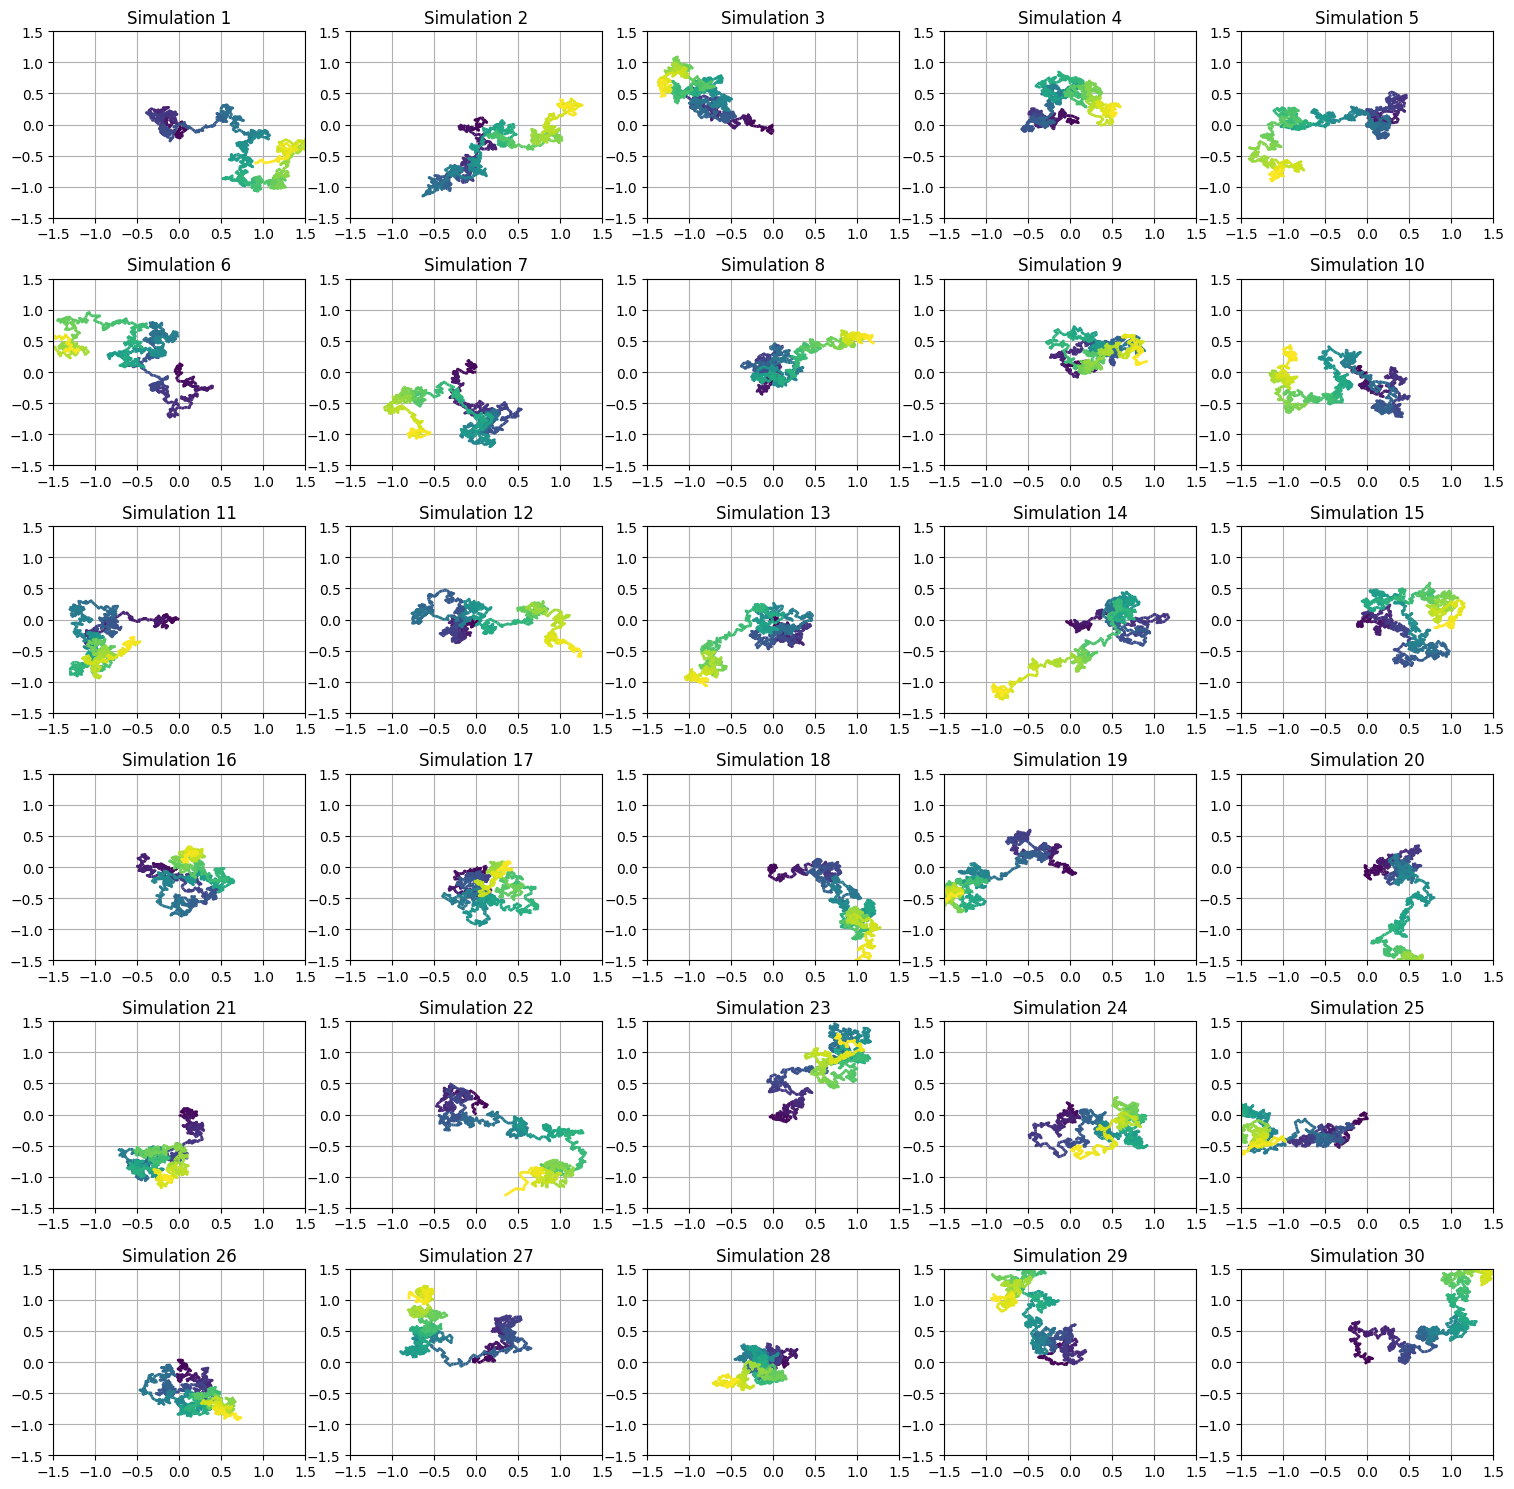

In [30]:
# Simulation parameters
num_steps = 1000
step_size = 0.05
chemotaxis_strength = 0.00  # Adjust this value to control the strength of chemotaxis

num_simulations = 30  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Create a figure with subplots for each simulation
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))

for i in range(num_simulations):
    # Initialize
    x = 0
    y = 0
    positions = [(x, y)]

    # Simulate with chemotaxis
    for _ in range(num_steps):
        # Calculate chemotaxis bias
        bias_x, bias_y = calculate_chemotaxis_bias(x, y, gradient_function)

        # Generate random step with bias
        step_x = np.random.uniform(-step_size, step_size) + bias_x * chemotaxis_strength
        step_y = np.random.uniform(-step_size, step_size) + bias_y * chemotaxis_strength

        x += step_x
        y += step_y
        positions.append((x, y))

    # Extract x and y coordinates
    x_coords, y_coords = zip(*positions)

    # Create timepoints for color mapping
    timepoints = np.linspace(0, 1, len(x_coords))

    # Plot the trajectory on the corresponding subplot
    ax = axes[i // 5, i % 5]  # Select the appropriate subplot
    line = colored_line(x_coords, y_coords, timepoints, ax, linewidth=2, cmap="viridis")
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f"Simulation {i+1}")
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

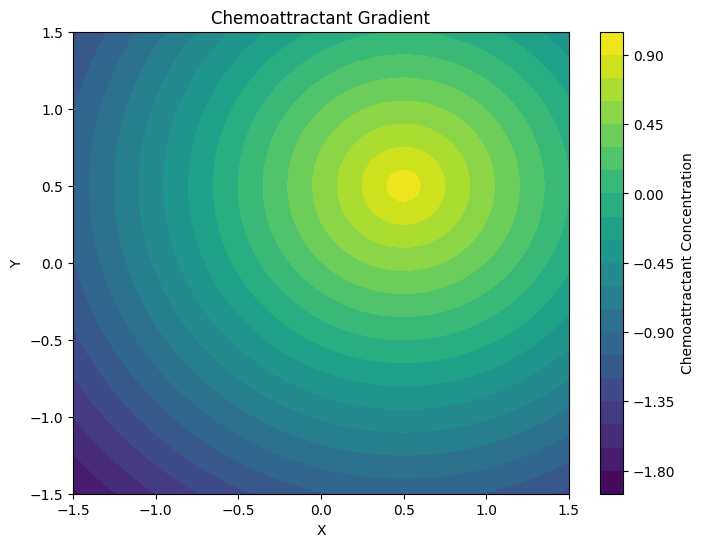

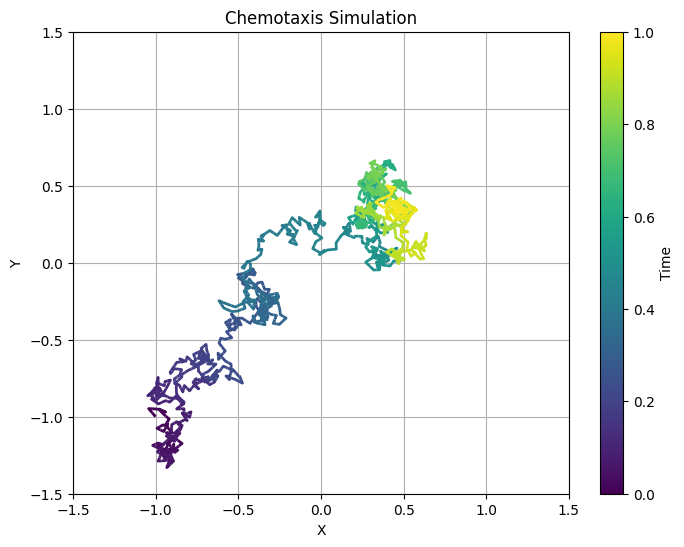

In [31]:
# Simulation parameters
num_steps = 1000
step_size = 0.05
chemotaxis_strength = 0.005  # Adjust this value to control the strength of chemotaxis

# Initialize
x = -1
y = -1
positions = [(x, y)]

# Choose gradient function (linear or radial)
#gradient_function = chemoattractant_gradient_linear  # Or 
gradient_function = chemoattractant_gradient_radial

# Simulate with chemotaxis
for _ in range(num_steps):
    # Calculate chemotaxis bias
    bias_x, bias_y = calculate_chemotaxis_bias(x, y, gradient_function)

    # Generate random step with bias
    step_x = np.random.uniform(-step_size, step_size) + bias_x * chemotaxis_strength
    step_y = np.random.uniform(-step_size, step_size) + bias_y * chemotaxis_strength

    x += step_x
    y += step_y
    positions.append((x, y))

# Extract x and y coordinates
x_coords, y_coords = zip(*positions)

# Create timepoints for color mapping
timepoints = np.linspace(0, 1, len(x_coords))

# Create the first plot (chemotaxis gradient)
plt.figure(figsize=(8, 6))
# Create a grid of x and y values
x = np.linspace(-1.5, 1.5, 800)
y = np.linspace(-1.5, 1.5, 800)
X, Y = np.meshgrid(x, y)

# Calculate the chemoattractant concentration at each point
Z = gradient_function(X, Y)

# Create a contour plot
CS = plt.contourf(X, Y, Z, 20, cmap='viridis')  # Adjust levels and colormap as needed
plt.colorbar(label='Chemoattractant Concentration')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Chemoattractant Gradient')

# Create the second plot (trajectory)
plt.figure(figsize=(8, 6))
line = colored_line(x_coords, y_coords, timepoints, plt.gca(), linewidth=2, cmap="viridis")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Chemotaxis Simulation')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Add colorbar
cbar = plt.colorbar(line, label='Time') 

plt.show()

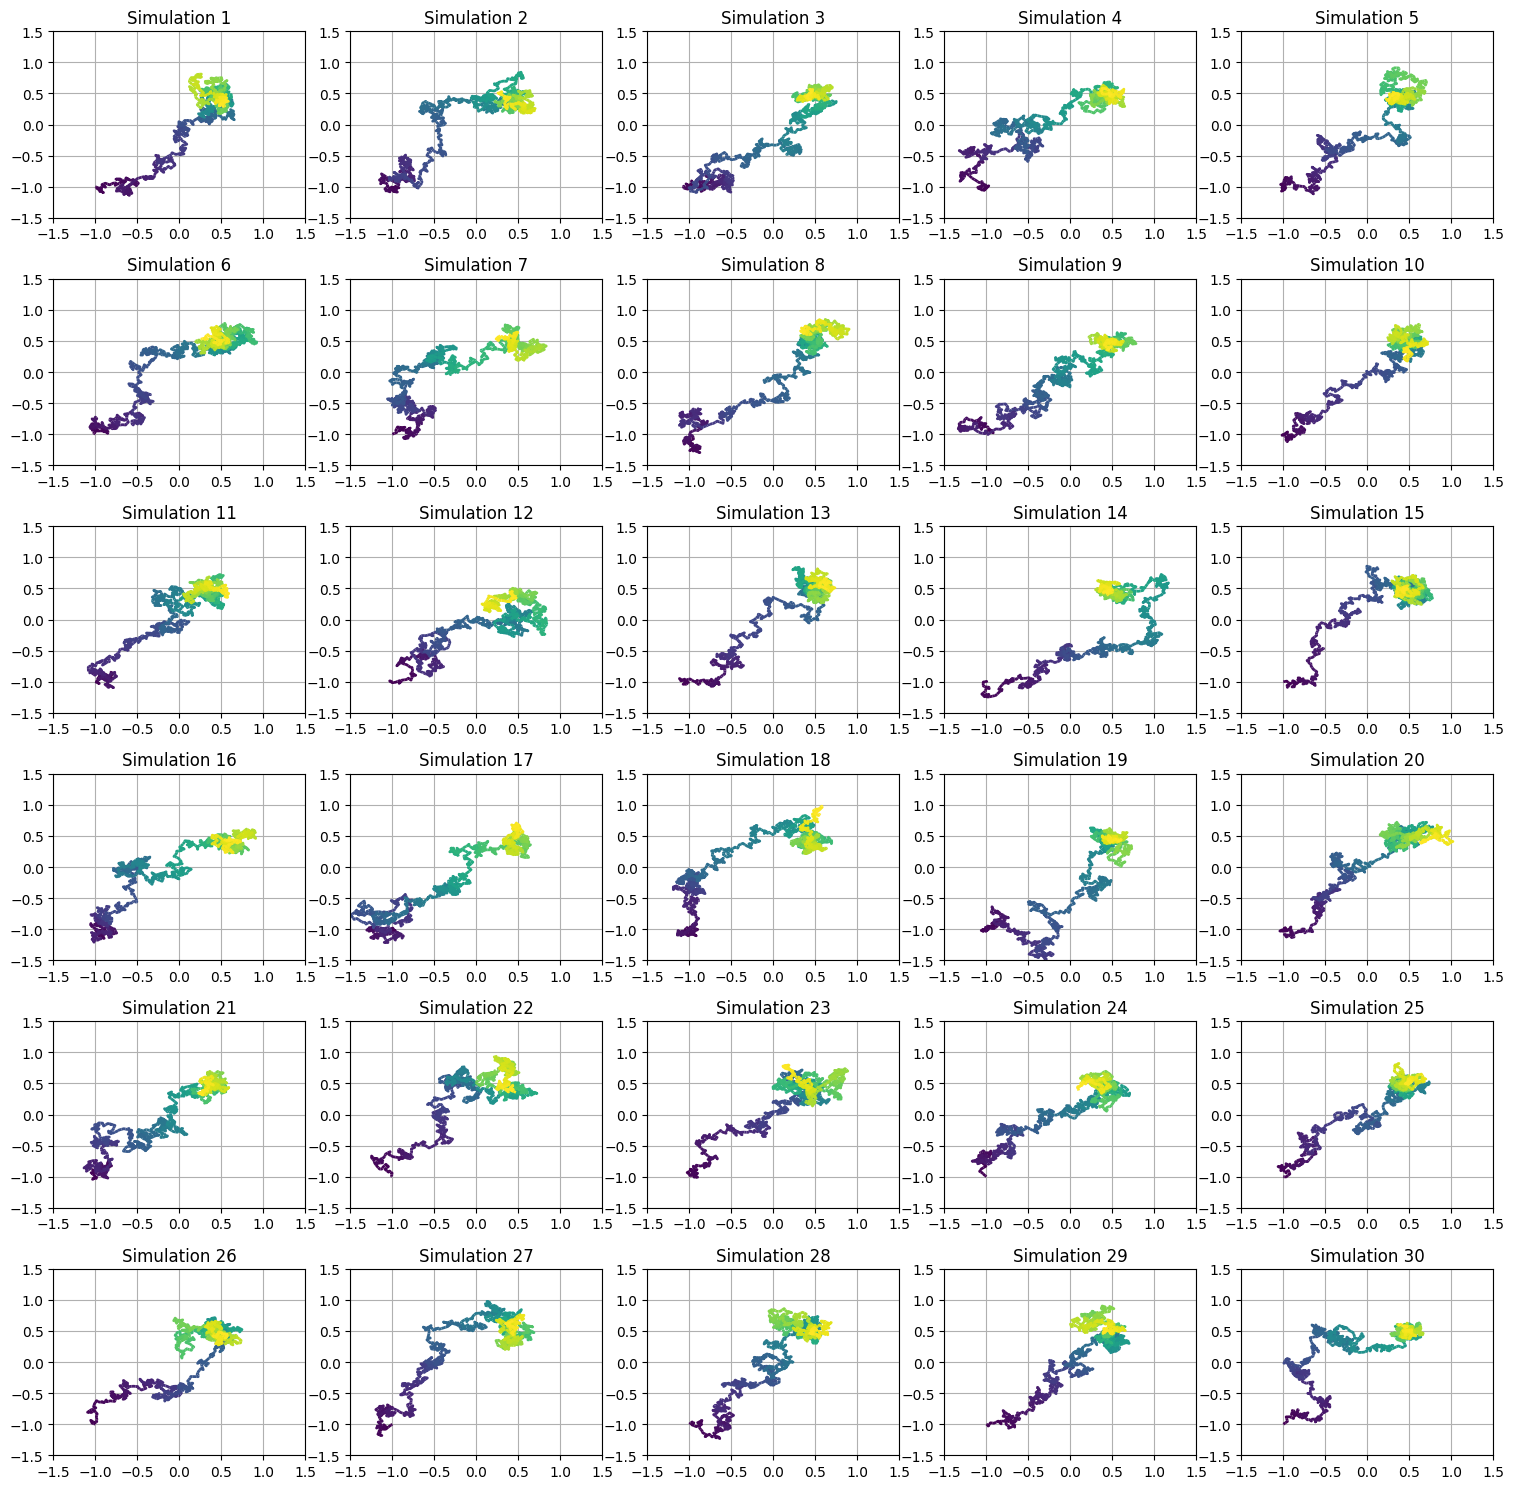

In [32]:
# Simulation parameters
num_steps = 1000
step_size = 0.05
chemotaxis_strength = 0.005  # Adjust this value to control the strength of chemotaxis

num_simulations = 30  # Number of simulations to run

# Choose gradient function (linear or radial)
gradient_function = chemoattractant_gradient_radial  # Or chemoattractant_gradient_linear

# Create a figure with subplots for each simulation
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))

for i in range(num_simulations):
    # Initialize
    x = -1
    y = -1
    positions = [(x, y)]

    # Simulate with chemotaxis
    for _ in range(num_steps):
        # Calculate chemotaxis bias
        bias_x, bias_y = calculate_chemotaxis_bias(x, y, gradient_function)

        # Generate random step with bias
        step_x = np.random.uniform(-step_size, step_size) + bias_x * chemotaxis_strength
        step_y = np.random.uniform(-step_size, step_size) + bias_y * chemotaxis_strength

        x += step_x
        y += step_y
        positions.append((x, y))

    # Extract x and y coordinates
    x_coords, y_coords = zip(*positions)

    # Create timepoints for color mapping
    timepoints = np.linspace(0, 1, len(x_coords))

    # Plot the trajectory on the corresponding subplot
    ax = axes[i // 5, i % 5]  # Select the appropriate subplot
    line = colored_line(x_coords, y_coords, timepoints, ax, linewidth=2, cmap="viridis")
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f"Simulation {i+1}")
    ax.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

plt.show()